# Problem:
Translating a color as RGB values into what a person with color vision deficiency would see can be done by multiplying the RGB vector by a matrix $M$ [[Machado et al. 2009]](https://www.inf.ufrgs.br/~oliveira/pubs_files/CVD_Simulation/CVD_Simulation.html). 
The goal in this notebook is to find the color pair $x, y \in [0, 1]^3$ that maximizes the Euclidean distance between the colors in the color space of a person with normal color vision and minimizes the Euclidean distance between the colors in the color space of a person with color vision deficiency. 
- Maximize: $\|x - y\|$ 
- Minimize: $\|Mx - My\|$ 
- Constraints: $x_i \in [0, 1]$, $y_i \in [0, 1]$

With $z = \begin{bmatrix}x \\ y \end{bmatrix}$, $\widetilde{M} = \begin{bmatrix} M & -M \end{bmatrix}$ and $\widetilde{I} = \begin{bmatrix} I_3 & -I_3 \end{bmatrix}$
the norms can be written as $\|Iz\|$ and $\|\widetilde{M}z\|$. 

With $A = I^T I$ and $B = \widetilde{M}^T \widetilde{M}$ the problem can then be formulated using the two quadratic forms $z^T A z$ and $z^T B z$.

As the screen only displays 256 values for each RGB entry, the resulting x and y are multiplied by 255 and rounded to the nearest integer. So in order for two colors to be indistinguishable for a colorblind person, the distance between x and y must be less than $\frac{0.5}{255}$, which gives an upper bound for $z^T B z$ of $\frac{0.5^2}{255^2} \approx 3.8 \cdot 10^{-7}$.

The problem therefore reduces to:

Maximize $z^T A z$ under the constraints $z^T B z \leq 3.8 \cdot 10^{-7}$ and $z \in [0, 1]^6$ with $A, B \in \mathbb{R}^{6 \times 6}$ both positive semi-definite.

This notebook uses the minimization of the objective function $\frac{z^T A z}{z^T B z}$ with the SLSQP solver to approximate a solution to the original problem. The program is run multiple times with different initial guesses to find a good solution, but since the solver is very sensitive to the initial guess the solutions have a lot of variance.

In [1]:
import colour
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
I = np.identity(3)
M = colour.blindness.matrix_cvd_Machado2009('Deuteranomaly', 1)

I_tilde = np.concatenate([I, -I], axis=1) # 3x6 Matrix
M_tilde = np.concatenate([M, -M], axis=1) # 3x6 Matrix

A = I_tilde.T@I_tilde
B = M_tilde.T@M_tilde

def objective(z):
    return z.T @ B @ z / (z.T @ A @ z + 1e-15)  # Adding a small constant to avoid division by zero

bounds = [(0, 1)]*6

current_best = np.inf
for _ in range(500):
    initial_guess = np.random.rand(6)
    result = minimize(objective, initial_guess, bounds=bounds, method='SLSQP')
    if result.fun < current_best:
        current_best = result.fun
        x, y = np.round(255*result.x[:3]), np.round(255*result.x[3:])

print('x:', x)
print('y:', y)
print('Distance between x and y:', np.linalg.norm(y - x))
print('Mx:', np.round(M.dot(x)))
print('My:', np.round(M.dot(y)))
print('Distance between Mx and My:', np.linalg.norm(np.round(M.dot(x)) - np.round(M.dot(y))))

x: [ 255.   79.  130.]
y: [   0.  186.  122.]
Distance between x and y: 276.655019835
Mx: [ 132.  131.  126.]
My: [ 132.  131.  126.]
Distance between Mx and My: 0.0


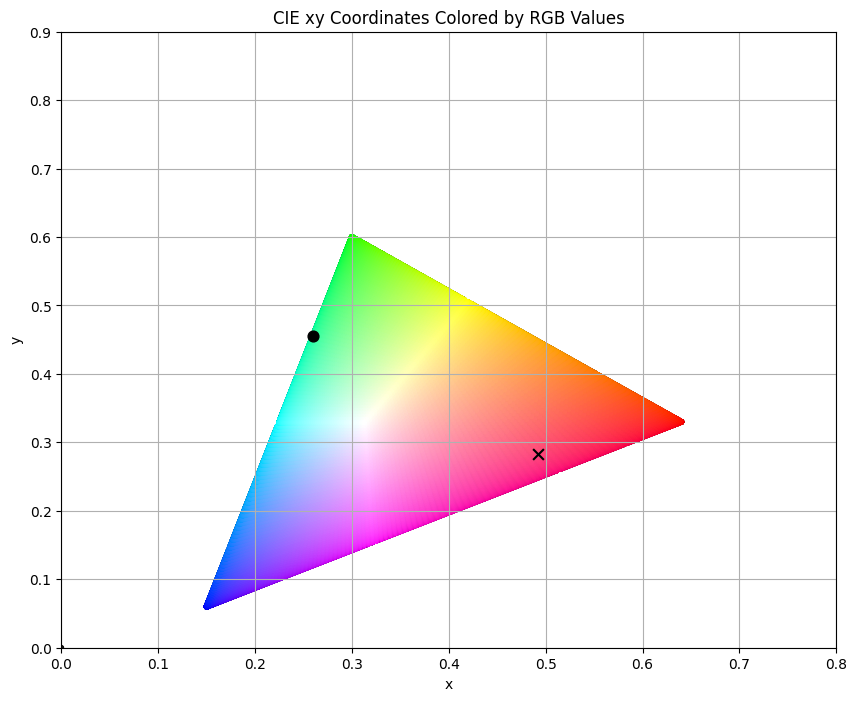

In [3]:
def create_colorspace_grid(resolution=10):
    r, g, b = np.meshgrid(np.linspace(0, 1, resolution),
                            np.linspace(0, 1, resolution),
                            np.linspace(0, 1, resolution))

    r = r.flatten()
    g = g.flatten()
    b = b.flatten()
    return np.vstack([r, g, b]).T

def rgb_to_xyz(rgb):
    rgb = rgb.copy()
    # Transformation matrix from sRGB to XYZ
    M = np.array([[0.4124564, 0.3575761, 0.1804375],
                  [0.2126729, 0.7151522, 0.0721750],
                  [0.0193339, 0.1191920, 0.9503041]])
    
    # Linearize the gamma-corrected RGB values
    mask = rgb <= 0.04045
    rgb[mask] = rgb[mask] / 12.92
    rgb[~mask] = np.power((rgb[~mask] + 0.055) / 1.055, 2.4)

    # Convert to XYZ
    return np.dot(rgb, M.T)

def xyz_to_xy(xyz):
    sum_xyz = np.sum(xyz, axis=1) + 1e-15  # Adding a small constant to avoid division by zero
    x = xyz[:, 0] / sum_xyz
    y = xyz[:, 1] / sum_xyz
    return np.stack((x, y), axis=1)

def rgb_to_cie_xy(rgb_array):
    xyz_array = rgb_to_xyz(rgb_array)
    return xyz_to_xy(xyz_array)

def plot_colored_coordinates(xy_coords, rgb_values, title, x_markers=None, y_markers=None):
    plt.figure(figsize=(10, 8))
    
    plt.scatter(xy_coords[:, 0], xy_coords[:, 1], c=rgb_values, s=10)
    
    if x_markers is not None:
        xy_coords_x = rgb_to_cie_xy(x_markers)
        plt.scatter(xy_coords_x[:, 0], xy_coords_x[:, 1], c='black', s=60, marker='x')

    if y_markers is not None:
        xy_coords_y = rgb_to_cie_xy(y_markers)
        plt.scatter(xy_coords_y[:, 0], xy_coords_y[:, 1], c='black', s=60, marker='o')

    plt.xlim([0, 0.8])
    plt.ylim([0, 0.9])

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid(True)
    return plt

x_markers = np.array([np.round(255*x)/255])
y_markers = np.array([np.round(255*y)/255])
colorspace = create_colorspace_grid(60)
cie_xy_coords = rgb_to_cie_xy(colorspace)
plot_colored_coordinates(cie_xy_coords, colorspace, 'CIE xy Coordinates Colored by RGB Values', x_markers=x_markers, y_markers=y_markers);

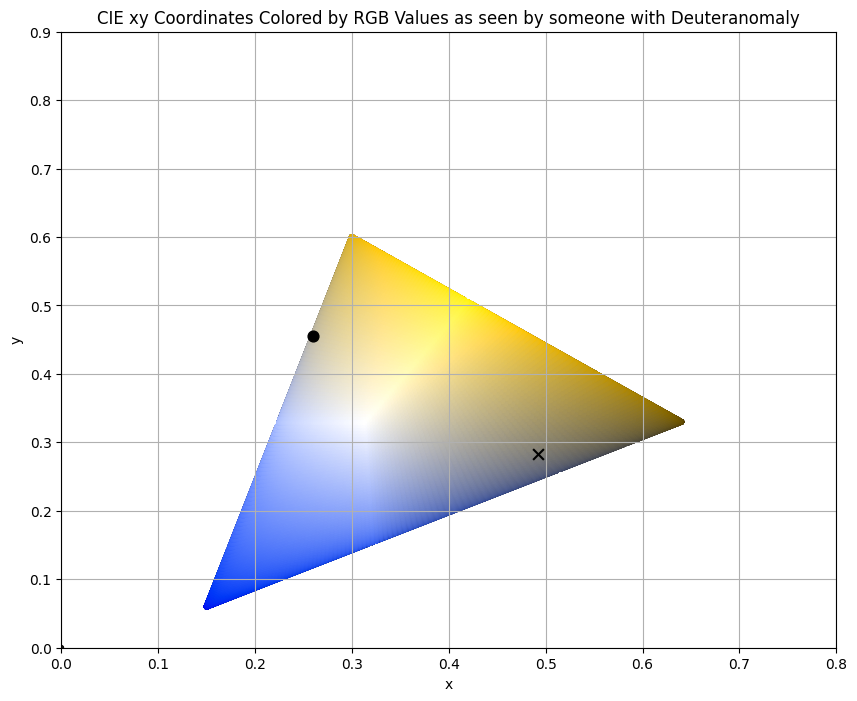

In [4]:
colors_cvd = M.dot(colorspace.T).T.clip(0,1)
plot_colored_coordinates(cie_xy_coords, colors_cvd, f'CIE xy Coordinates Colored by RGB Values as seen by someone with Deuteranomaly', x_markers=x_markers, y_markers=y_markers);